# Multiedge dichroic analysis

We have been quoted £12.5K from Laser2000 for a five band multiedge dichroic filter, and been sent a prospective spectral specification. We expect that we are likely to see some decrease in spectral discrimination performance linked to this more complex filter, and possibly a decrease in peak transmission in any given band linked to the more complicated fabrication process. 

<i>How bad is this performance drop? </i>

__Sources for dye data:__

Atto general properties: https://www.atto-tec.com/fileadmin/user_upload/Katalog_Flyer_Support/Dye_Properties_01.pdf

Atto spectra: https://www.atto-tec.com/attotecshop/product_info.php?language=en&info=p117_ATTO-700.html

Alexa 405 absorption coefficient: http://www.atdbio.com/content/34/Alexa-dyes

Alexa 405 QY: http://confocal-microscopy-list.588098.n2.nabble.com/alexa-405-QY-td6913848.html

Alexa 405 spectra: https://www.chroma.com/spectra-viewer?fluorochromes=10533


__Sources for filter spectra:__

Semrock filters: http://www.laser2000.co.uk

Chroma 700 dichroics: emailed from Chroma

General Chroma filters: https://www.chroma.com/products/


__Sources for camera spectra:__

Andor Zyla 5.5: https://searchlight.semrock.com/


__Sources for optics (objective) spectra:__

UPLANSAPO20x: https://www.olympus-lifescience.com/en/objectives/uplsapo/#!cms[tab]=%2Fobjectives%2Fuplsapo%2F20x, data extracted from curve using WebPlotDigitiser: http://arohatgi.info/WebPlotDigitizer/app/


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dye import Dye
from laser import Laser
from filterCube import FilterCube
from interferenceFilter import InterferenceFilter
from broadbandSource import BroadbandSource
from camera import Camera
from objective import Objective
import utils
from crosstalk_analysis import signalFromDyeXInChannelY
from crosstalk_analysis import displayCrosstalkPlot
from crosstalk_analysis import calcLeakage
from crosstalk_analysis import showDyeEmissionEnclosedByFilters

dyesPath = 'Dye spectra/'
filtersPath = 'Filter spectra/'
opticsPath =  'Optics spectra/'
cameraPath = 'Camera spectra/'
sourcesPath = 'Source spectra/'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Dyes

In [2]:
dye405 = Dye(name = 'Alexa405', epsilon = 35000, qy = 0.54, 
             absSpectrum = os.path.join(dyesPath, 'Alexa405abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'Alexa405em.txt'))
          
dye532 = Dye(name = 'Atto532', epsilon = 115000, qy = 0.9, 
             absSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.ems.txt'))

dye594 = Dye(name = 'Atto594', epsilon = 120000, qy = 0.85, 
             absSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.ems.txt'))

dye633 = Dye(name = "Atto655", epsilon = 125000, qy = 0.3, 
          absSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.ems.txt') )        

dye700 = Dye(name = "Atto700", epsilon = 120000, qy = 0.25, 
          absSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.ems.txt') )   

dyes = [dye405, dye532, dye594, dye633, dye700]

### Light source

In [3]:
l405 = Laser(channel = 'L405Nm', centreWavelengthNm = 405, fwhmNm = 0.01, 
             laserOutputPowerMw = 3)
             
l532 = Laser(channel = 'L532Nm', centreWavelengthNm = 532, fwhmNm = 0.01, 
             laserOutputPowerMw = 18)
             
l594 = Laser(channel = 'L594Nm', centreWavelengthNm = 594, fwhmNm = 0.01, 
             laserOutputPowerMw = 25)             
          
l633 = Laser(channel = 'L633Nm', centreWavelengthNm = 640, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
          
l700 = Laser(channel = 'L700Nm', centreWavelengthNm = 701, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
             
lasers = [l405, l532, l594, l633, l700]

### Camera

In [4]:
camera = Camera(name = 'Andor Zyla 5.5', 
                qeCurve = os.path.join(cameraPath, 'Camera sCMOS (Andor- Zyla 5.5).txt'), 
                sensorSizeXYMm = (14.0, 16.6), 
                sensorSizeXYPix = (2560, 2160))


### Objective

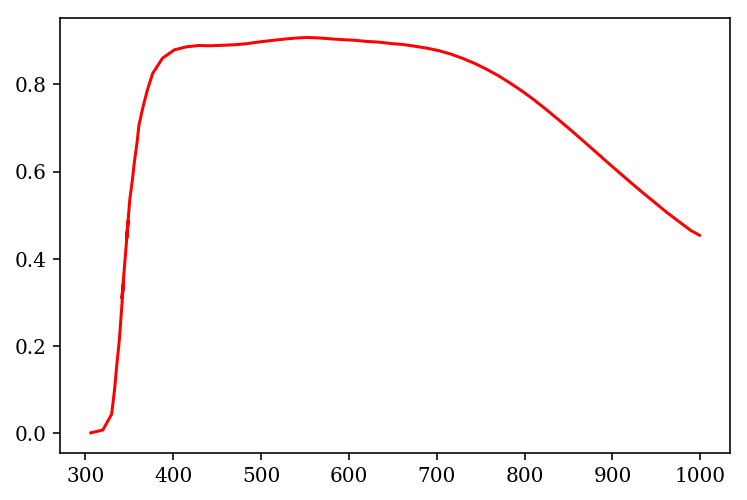

In [14]:
objective = Objective(name = 'Olympus UPLANSAPO20x 0.75NA', 
                      transmissionCurve = os.path.join(opticsPath, 'Olympus UPLANSAPO20x.txt'))


## Existing system filter cube system

In [6]:
fc405 = FilterCube(channel = 'L405Nm', 
                   excitationFilter = ( 'FF01-390_40', os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R405', os.path.join(filtersPath, 'Di02-R405_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )
                   
fc532 = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R532', os.path.join(filtersPath, 'Di02-R532_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) )
                   
fc594 = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R594', os.path.join(filtersPath, 'Di02-R594_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-647_57', os.path.join(filtersPath, 'FF01-647_57_Spectrum.txt') ) )
             
fc633 = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R635', os.path.join(filtersPath, 'Di02-R635_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                                      
fc700 = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( '725lpxr', os.path.join(filtersPath, 'Chroma 725lpxr.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )

fc_current = [fc405, fc532, fc594, fc633, fc700]

## Multiedge filter system

Here we consider the effects of keeping all other filters identitical, and simply changing the dichroic. This is relevant for a straight swap into the scan rigs, the main benefit of which will be removing (*subject to depth considerations*) the lateral offsets introduced by multiple dichroics at subtly different angles. 

(350, 800)

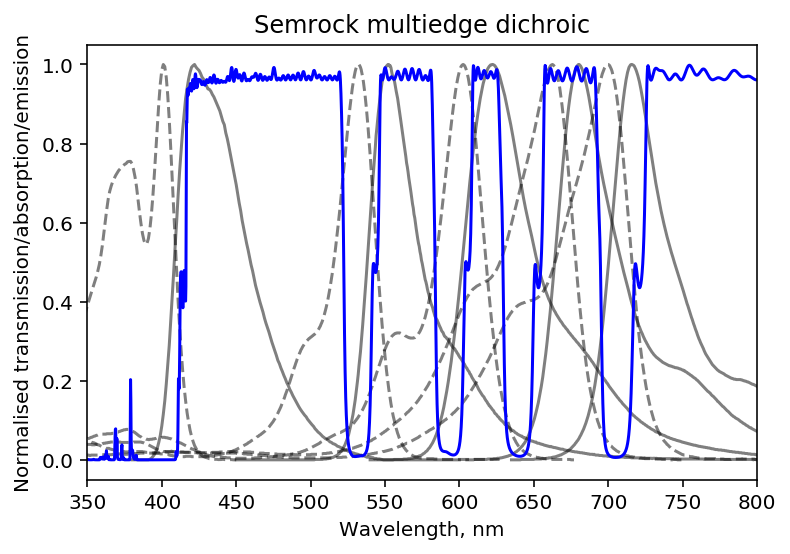

In [7]:
fc405multi = FilterCube(channel = 'L405Nm', 
                   excitationFilter = ( 'FF01-390_40', os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ),  
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )
                   
fc532multi = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ),  
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) )
                   
fc594multi = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ),  
                   emissionFilter = ( 'FF01-647_57', os.path.join(filtersPath, 'FF01-647_57_Spectrum.txt') ) )
             
fc633multi = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                   
fc700multi = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )

fc_multi_old_filts = [fc405multi, fc532multi, fc594multi, fc633multi, fc700multi]

hfig = plt.figure()
for d in dyes:
    plt.plot(d.absorptionSpectrum[:,0], d.absorptionSpectrum[:,1], 'k--', alpha=0.5)
    plt.plot(d.emissionSpectrum[:,0], d.emissionSpectrum[:,1], 'k-', alpha=0.5)
    
plt.plot(fc405multi.dichroicFilter.getSpectrum()[:,0], fc405multi.dichroicFilter.getSpectrum()[:,1], 'b-')
plt.title('Semrock multiedge dichroic')
plt.ylabel('Normalised transmission/absorption/emission')
plt.xlabel('Wavelength, nm')
plt.xlim((350, 800))

### Signal compared to current scan rig

Signal ratio in channel L405Nm = 1.010
Signal ratio in channel L532Nm = 0.942
Signal ratio in channel L594Nm = 0.634
Signal ratio in channel L633Nm = 0.835
Signal ratio in channel L700Nm = 1.076


Text(0.5,1,'Comparison of Semrock multiedge and current setup')

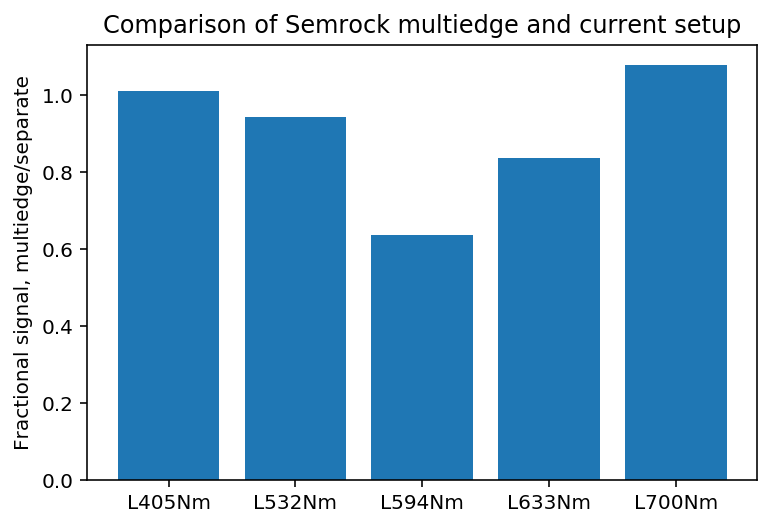

In [8]:
ratios_sem = []
ch_labels = []

for l, f_old, f_new, dy in zip(lasers, fc_current, fc_multi_old_filts, dyes):
    d, ch, sig_new = signalFromDyeXInChannelY(l, f_new, dy, objective, camera)
    d, ch, sig_old = signalFromDyeXInChannelY(l, f_old, dy, objective, camera)
    
    ratios_sem.append(sig_new/sig_old)
    ch_labels.append(ch)
    print('Signal ratio in channel {} = {:0.3f}'.format(ch, (sig_new/sig_old)))

#     ol1 = show_dye_emission_enclosed_by_filters(dy, f_old, objective, camera, title='Separate dichroics')
#     ol2 = show_dye_emission_enclosed_by_filters(dy, f_new, objective, camera, title='Multiedge dichroic')

    
fig1 = plt.figure()
plt.bar([1, 2, 3, 4, 5], 
        ratios_sem, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Fractional signal, multiedge/separate')
plt.title('Comparison of Semrock multiedge and current setup')

### Crosstalk compared to current scan rig

C:\Users\d.kelly\Documents\DyeAnalysis\crosstalk_analysis.py:96: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(crosstalkMatrix), cmap = 'Reds', interpolation='none')


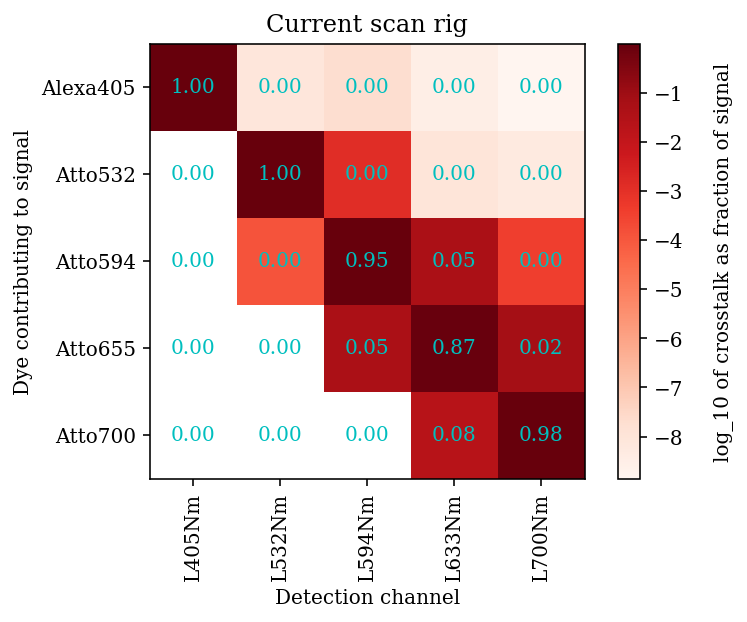

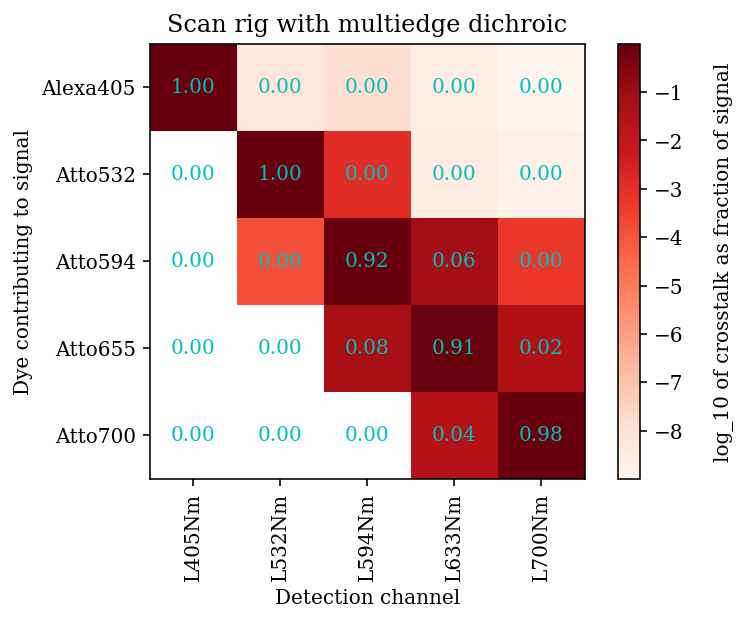

array([[  9.99999977e-01,   6.18577654e-09,   1.29606637e-08,
          2.82483378e-09,   1.02210795e-09],
       [  0.00000000e+00,   9.98829293e-01,   1.17070224e-03,
          3.43915954e-09,   1.70798175e-09],
       [  0.00000000e+00,   1.34102199e-04,   9.23186003e-01,
          7.60929146e-02,   5.86980093e-04],
       [  0.00000000e+00,   0.00000000e+00,   5.50971171e-02,
          9.09057641e-01,   3.58452416e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.25448717e-02,   9.77455128e-01]])

In [9]:
displayCrosstalkPlot(lasers, 
                     fc_current, 
                     dyes, 
                     objective, 
                     camera, 
                     title="Current scan rig")

displayCrosstalkPlot(lasers, 
                     fc_multi_old_filts, 
                     dyes, 
                     objective, 
                     camera, 
                     title="Scan rig with multiedge dichroic")


## Leakage compared to current scan rig

Implicit assumptions:
* All excitation that gets to the sample plane is efficiently backscattered - i.e. sample plane is a mirror. Might not be so far removed from reality for large changes in refractive index? 
* Backscattered light is spread uniformly over detector area. 

Best to consider this a comparison rather than giving absolute numbers?

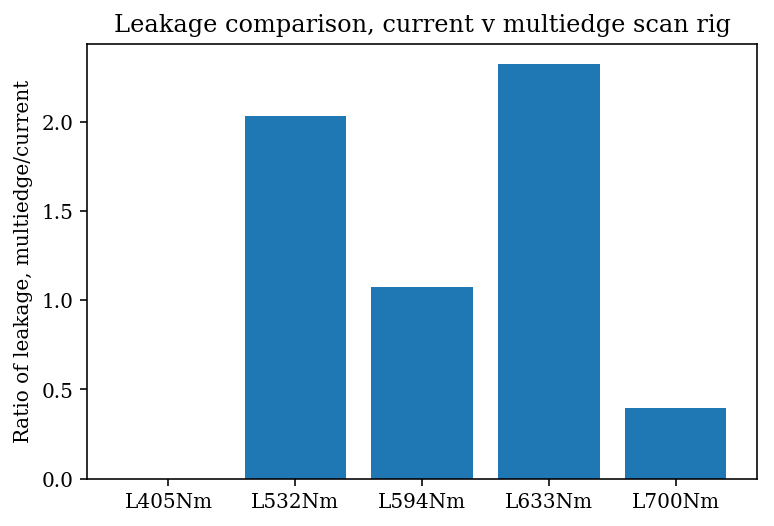

In [15]:
absolute_current_leak = [calcLeakage(sr, fc, objective) for sr, fc in zip(lasers, fc_current)]
absolute_multiedge_leak = [calcLeakage(sr, fc, objective) for sr, fc in zip(lasers, fc_multi_old_filts)]
leak_ratio = [(ml/cl) for cl, ml in zip(absolute_current_leak, absolute_multiedge_leak)]
fig5 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        leak_ratio, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Ratio of leakage, multiedge/current')
plt.title('Leakage comparison, current v multiedge scan rig')
plt.show()

In [ ]:
l 

photon_multiedge_leak = [leak/lsr for leak, lsr in zip(absolute_multiedge_leak, lasers)]

## Broadband source, multiedge filter

Here we consider the effects of making changes to the choice of filters manually/by inspection, in addition to swapping laser light sources for a white light source matching the spectrum of the Thorlabs plasma lamp. *IMPORTANT: this does not consider etendue effects, only spectral ones!*